In [1]:
%matplotlib inline

from collections import Counter
import gc
import re
from pathlib import Path
from scipy.sparse import csr_matrix, hstack
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, StratifiedKFold, KFold, cross_val_score

import warnings
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=FutureWarning)

In [2]:
PATH = Path('../input')
[f.name for f in PATH.iterdir()]

['train_sessions.csv',
 'site_dic.pkl',
 'sample_submission.csv',
 'train.zip',
 'test_sessions.csv']

In [3]:
sites = [f'site{i}' for i in range(1, 11)]
times = [f'time{i}' for i in range(1, 11)]

In [4]:
train_df = pd.read_csv(PATH/'train_sessions.csv', parse_dates=times, nrows=None)
print(train_df.shape)
train_df.head()

(253561, 22)


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
3,4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
4,5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [5]:
test_df = pd.read_csv(PATH/'test_sessions.csv', parse_dates=times, nrows=None)
print(test_df.shape)
test_df.head()

(82797, 21)


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
0,1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
1,2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
2,3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
3,4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
4,5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [6]:
sites_df = pd.read_pickle(PATH/'site_dic.pkl')
sites_df = {int(v):k.strip() for k, v in sites_df.items()}
sites_df = pd.Series(sites_df).sort_index()
print(sites_df.shape)
sites_df.head()

(48371,)


1    fpdownload2.macromedia.com
2                    hotmail.fr
3                login.live.com
4                 mail.live.com
5          dub122.mail.live.com
dtype: object

In [7]:
train_df[sites] = train_df[sites].astype(np.float32)
test_df[sites] = test_df[sites].astype(np.float32)

In [8]:
train_df['target'].value_counts(normalize=True)

0    0.990941
1    0.009059
Name: target, dtype: float64

In [9]:
%%time

for df in [train_df, test_df]:
    df['num_sites'] = df[sites].count(axis=1)
    df['nunique_sites'] = df[sites].nunique(axis=1)

CPU times: user 27 s, sys: 88 ms, total: 27.1 s
Wall time: 27 s


In [10]:
train_df[sites] = train_df[sites].fillna(0).astype(np.float32)
test_df[sites] = test_df[sites].fillna(0).astype(np.float32)

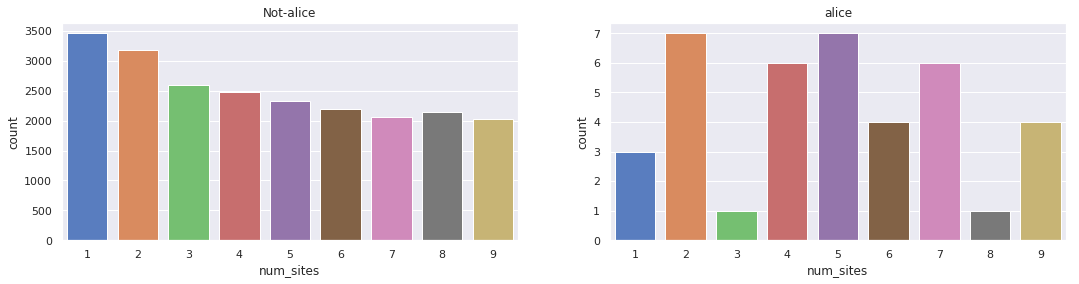

In [11]:
_, ax = plt.subplots(1, 2, figsize=(18, 4))
sns.countplot(train_df.loc[(train_df['target'] == 0) & (train_df['num_sites'] < 10), 'num_sites'], ax=ax[0])
sns.countplot(train_df.loc[(train_df['target'] == 1) & (train_df['num_sites'] < 10), 'num_sites'], ax=ax[1])
ax[0].set_title('Not-alice')
ax[1].set_title('alice');

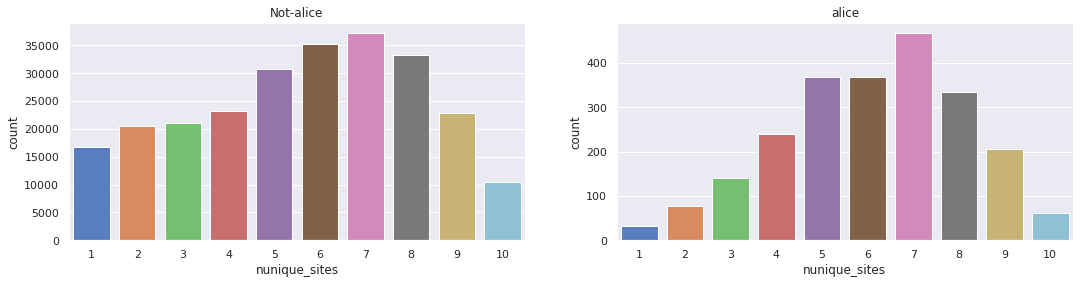

In [12]:
_, ax = plt.subplots(1, 2, figsize=(18, 4))
sns.countplot(train_df.loc[train_df['target'] == 0, 'nunique_sites'], ax=ax[0])
sns.countplot(train_df.loc[train_df['target'] == 1, 'nunique_sites'], ax=ax[1])
ax[0].set_title('Not-alice')
ax[1].set_title('alice');

In [13]:
top_alice_sites = pd.Series(train_df.loc[train_df['target'] == 1, sites].values.flatten()).value_counts(ascending=False)
top_alice_sites = pd.Series(top_alice_sites.index.values, index=top_alice_sites).head(20).reset_index(drop=True)
top_alice_sites.head()

0    77.0
1    80.0
2    76.0
3    29.0
4    21.0
dtype: float64

In [14]:
%%time

train_df['num_alice_sites'] = train_df[sites].apply(
    lambda sites: sum([c for site, c in Counter(sites.values).items() if site in top_alice_sites.values]), axis=1)
train_df['avg_alice_sites'] = train_df['num_alice_sites'] / train_df['num_sites']

test_df['num_alice_sites'] = test_df[sites].apply(
    lambda sites: sum([c for site, c in Counter(sites.values).items() if site in top_alice_sites.values]), axis=1)
test_df['avg_alice_sites'] = test_df['num_alice_sites'] / test_df['num_sites']

CPU times: user 15.7 s, sys: 20 ms, total: 15.7 s
Wall time: 15.7 s


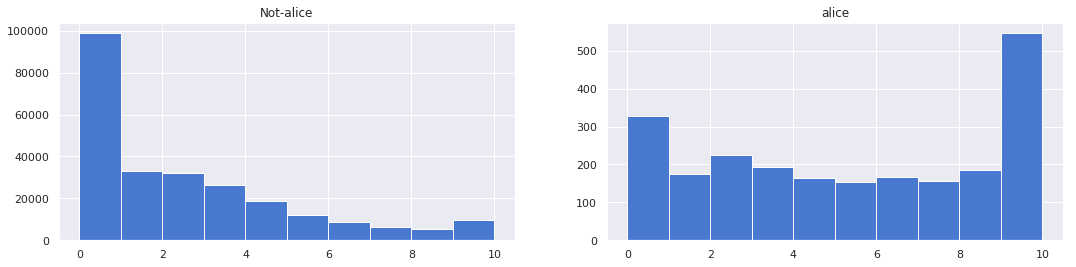

In [15]:
_, ax = plt.subplots(1, 2, figsize=(18, 4))
train_df.loc[train_df['target'] == 0, 'num_alice_sites'].hist(ax=ax[0])
train_df.loc[train_df['target'] == 1, 'num_alice_sites'].hist(ax=ax[1])
ax[0].set_title('Not-alice')
ax[1].set_title('alice');

In [16]:
%%time

train_df['site_len'] = train_df[sites].apply(
    lambda sites: np.mean([len(sites_df[site]) for site in set(sites.values) if site > 0]), axis=1)
test_df['site_len'] = test_df[sites].apply(
    lambda sites: np.mean([len(sites_df[site]) for site in set(sites.values) if site > 0]), axis=1)

CPU times: user 40.4 s, sys: 88 ms, total: 40.5 s
Wall time: 40.4 s


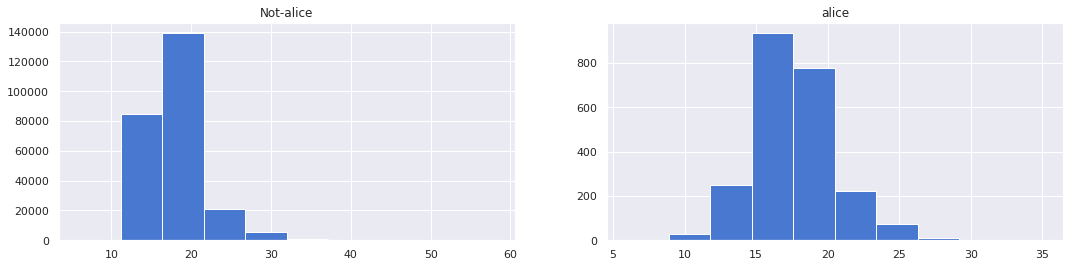

In [17]:
_, ax = plt.subplots(1, 2, figsize=(18, 4))
train_df.loc[train_df['target'] == 0, 'site_len'].hist(ax=ax[0])
train_df.loc[train_df['target'] == 1, 'site_len'].hist(ax=ax[1])
ax[0].set_title('Not-alice')
ax[1].set_title('alice');

In [18]:
# Time
for df in [train_df, test_df]:
    df['duration'] = (df[times].max(axis=1) - df[times].min(axis=1)).dt.seconds
    df['avg_duration'] = df['duration'] / df['nunique_sites']
    df['start_hour'] = np.ceil(df['time1'].dt.hour + (df['time1'].dt.minute / 60)).astype(np.int32)
    df.loc[df['start_hour'] == 24, 'start_hour'] = 0
    df['start_month'] = df['time1'].dt.month
    df['start_year'] = df['time1'].dt.year
    df['start_weekday'] = df['time1'].dt.dayofweek
    df['start_weekend'] = (df['start_weekday'] > 4).astype(np.int32)
    df['start_daytime'] = pd.cut(df['start_hour'], bins=[-1, 6, 11, 18, 23], labels=[0, 1, 2, 3]).astype(np.int32)

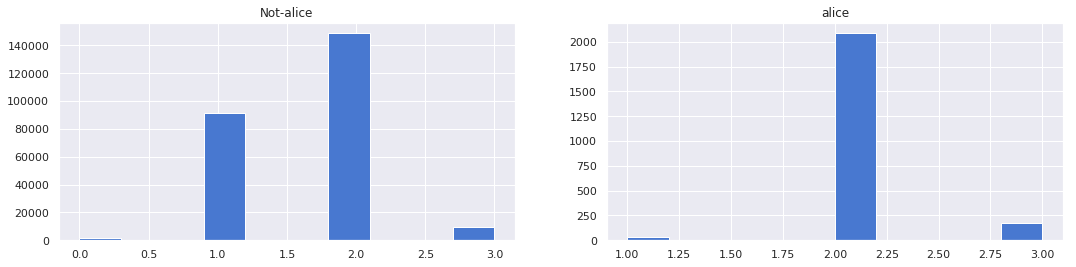

In [19]:
_, ax = plt.subplots(1, 2, figsize=(18, 4))
train_df.loc[train_df['target'] == 0, 'start_daytime'].hist(ax=ax[0])
train_df.loc[train_df['target'] == 1, 'start_daytime'].hist(ax=ax[1])
ax[0].set_title('Not-alice')
ax[1].set_title('alice');

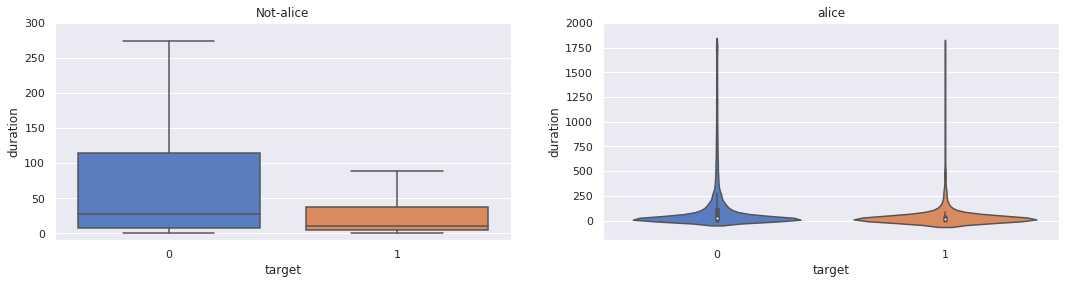

In [20]:
_, ax = plt.subplots(1, 2, figsize=(18, 4))
sns.boxplot(x='target', y='duration', data=train_df, ax=ax[0], showfliers=False)
sns.violinplot(x='target', y='duration', data=train_df, ax=ax[1], showfliers=False)
ax[0].set_title('Not-alice')
ax[1].set_title('alice')
ax[0].set_ylim(-10, 300), ax[1].set_ylim(-200, 2000);

In [21]:
for df in [train_df, test_df]:
    df['sites'] = df[sites].astype(np.str).apply(' '.join, axis=1)

In [22]:
# Uniform distribution
def uniform_distribute(df, target_col='target'):
    df['rounded_target'] = df[target_col].round(0)
    df = df.sort_values('rounded_target').reset_index(drop=True)
    vc = df['rounded_target'].value_counts()
    vc = dict(sorted(vc.items()))
    df2 = pd.DataFrame()
    df['indexcol'], i = 0, 1

    for k, v in vc.items():
        step = df.shape[0] / v
        indent = df.shape[0] / (v + 1)
        df3 = df[df['rounded_target'] == k].sample(v, random_state=120).reset_index(drop=True)
        for j in range(0, v):
            df3.at[j, 'indexcol'] = indent + j * step + 0.000001 * i
        df2 = pd.concat([df3, df2])
        i += 1

    df = df2.sort_values('indexcol', ascending=True).reset_index(drop=True)
    del df['indexcol'], df['rounded_target']
    gc.collect()
    return df

In [23]:
train_df.to_csv('train.csv', header=True, index=False)
test_df.to_csv('test.csv', header=True, index=False)

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df = uniform_distribute(train_df, 'target')

In [24]:
vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(1, 7))
train_sites = vectorizer.fit_transform(train_df['sites'])
test_sites = vectorizer.transform(test_df['sites'])

### Model

In [25]:
# reduce memory
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))
    return df

In [26]:
# ['num_sites', 'nunique_sites']

In [27]:
y_train = train_df.pop('target')
test_ids = test_df['session_id'].values
drop_cols = sites + times + ['sites', 'session_id']

train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

In [28]:
# One hot
cols_to_onehot = ['start_weekday', 'start_month', 'start_daytime', 'start_hour', 'start_weekend', 'start_year', 'num_sites', 'nunique_sites']
full_df = pd.concat([train_df, test_df])
full_df = pd.get_dummies(full_df, columns = cols_to_onehot, drop_first=True)
train_df, test_df = full_df.iloc[:train_df.shape[0]], full_df.iloc[train_df.shape[0]:]
del full_df
gc.collect()

# Standard scale
cols_to_scale = ['duration', 'avg_duration', 'site_len', 'num_alice_sites', 'avg_alice_sites']
scaler = StandardScaler()
train_df[cols_to_scale] = scaler.fit_transform(train_df[cols_to_scale])
test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

train_df.shape, test_df.shape

Memory usage after optimization is: 17.89 MB
Decreased by 28.8%
Memory usage after optimization is: 5.84 MB
Decreased by 28.8%


((253561, 61), (82797, 61))

In [29]:
X_train = csr_matrix(hstack([train_df, train_sites]))
X_test = csr_matrix(hstack([test_df, test_sites]))

In [30]:
def create_submission(preds, num=0):
    submission = pd.DataFrame({'session_id': test_ids, 'target': test_preds})
    submission.to_csv(f'submission_{num}.csv', header=True, index=False)

In [31]:
# time_split_cv = TimeSeriesSplit(10)
# skfold_split_cv = StratifiedKFold(10)
kfold_split_cv = KFold(10)

In [32]:
params = {
    'C': np.logspace(-2, 2, 10),
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(estimator=LogisticRegression(random_state=7, solver='sag'), param_grid=params, scoring='roc_auc', cv=2, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train);

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.3min finished


In [33]:
model = grid.best_estimator_
grid.best_score_, grid.best_params_

(0.9864256644481574, {'C': 4.6415888336127775, 'class_weight': 'balanced'})

In [34]:
# time_cv_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=time_split_cv , n_jobs=-1, verbose=1)
# time_cv_scores.mean(), time_cv_scores.std(), time_cv_scores

In [35]:
# skfold_cv_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=skfold_split_cv , n_jobs=-1, verbose=1)
# skfold_cv_scores.mean(), skfold_cv_scores.std(), skfold_cv_scores

In [36]:
kfold_cv_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=kfold_split_cv , n_jobs=-1, verbose=1)
kfold_cv_scores.mean(), kfold_cv_scores.std(), kfold_cv_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.6min finished


(0.9890518973142163,
 0.0027068338549742785,
 array([0.99228961, 0.99174301, 0.98971254, 0.9884628 , 0.98958034,
        0.98940107, 0.98870454, 0.98171044, 0.98953985, 0.98937477]))

In [37]:
test_preds = grid.predict_proba(X_test)[:, 1]
create_submission(test_preds, 1)